## Import data and libaries

In [1]:
# Import the libraries we need
import pandas as pd

# Read the World Bank development indicators dataset

worldbank_path = "../additional_material/week_05_world_bank_development_indicators.csv"
worldbank = pd.read_csv(worldbank_path)

# Read the income dataset (Excel file)
income_path = "../additional_material/week_05_income.xlsx"
income = pd.read_excel(income_path)

# Show the first rows of each dataset to confirm that everything loaded correctly
print("World Bank indicators dataset:")
print(worldbank.head())

print("\nIncome dataset:")
print(income.head())


World Bank indicators dataset:
       country        date  agricultural_land%  forest_land%  land_area  \
0  Afghanistan  1960-01-01                 NaN           NaN        NaN   
1  Afghanistan  1961-01-01           57.878356           NaN   652230.0   
2  Afghanistan  1962-01-01           57.955016           NaN   652230.0   
3  Afghanistan  1963-01-01           58.031676           NaN   652230.0   
4  Afghanistan  1964-01-01           58.116002           NaN   652230.0   

   avg_precipitation  trade_in_services%  control_of_corruption_estimate  \
0                NaN                 NaN                             NaN   
1              327.0                 NaN                             NaN   
2              327.0                 NaN                             NaN   
3              327.0                 NaN                             NaN   
4              327.0                 NaN                             NaN   

   control_of_corruption_std  access_to_electricity%  ...  \


## Are the countries equivalent in both datasets?

In [2]:
# 1. Keep only real countries in the income dataset
#    Idea: real countries have an "Income group", regions usually do NOT
income_countries_df = income[income["Income group"].notna()]

# 2. Get the list of country names from both datasets
income_countries = income_countries_df["Economy"].dropna().unique()
worldbank_countries = worldbank["country"].dropna().unique()

print("Number of countries in income dataset:", len(income_countries))
print("Number of countries in World Bank dataset:", len(worldbank_countries))

# 3. Convert to sets for an easy comparison
income_countries_set = set(income_countries)
worldbank_countries_set = set(worldbank_countries)

# 4. Countries that are in income.xlsx but NOT in the World Bank indicators
only_in_income = income_countries_set - worldbank_countries_set

# 5. Countries that are in the World Bank indicators but NOT in income.xlsx
only_in_worldbank = worldbank_countries_set - income_countries_set

print("\nCountries only in income dataset (not in World Bank):")
print(sorted(only_in_income))

print("\nCountries only in World Bank dataset (not in income dataset):")
print(sorted(only_in_worldbank))


Number of countries in income dataset: 216
Number of countries in World Bank dataset: 274

Countries only in income dataset (not in World Bank):
['Curaçao', 'Côte d’Ivoire', 'Puerto Rico (U.S.)', 'Somalia, Fed. Rep.', 'São Tomé and Príncipe', 'Taiwan, China', 'Türkiye']

Countries only in World Bank dataset (not in income dataset):
['Africa Eastern and Southern', 'Africa Western and Central', 'Arab World', 'Caribbean small states', 'Central Europe and the Baltics', "Cote d'Ivoire", 'Curacao', 'Czech Republic', 'Early-demographic dividend', 'East Asia & Pacific', 'East Asia & Pacific (IDA & IBRD countries)', 'East Asia & Pacific (IDA & IBRD)', 'East Asia & Pacific (excluding high income)', 'Ethiopia', 'Euro area', 'Europe & Central Asia', 'Europe & Central Asia (IDA & IBRD countries)', 'Europe & Central Asia (IDA & IBRD)', 'Europe & Central Asia (excluding high income)', 'European Union', 'Fragile and conflict affected situations', 'Heavily indebted poor countries (HIPC)', 'High income'

They are not. We will now convert the unique names from the income dataset into the equivalent names of the world bank dataset, so that we can merge them afterwards.

In [3]:
# Clean the country names in the income dataset

rename_dict = {
    "Curaçao": "Curacao",
    "Côte d’Ivoire": "Cote d'Ivoire",
    "Puerto Rico (U.S.)": "Puerto Rico",
    "Somalia, Fed. Rep.": "Somalia",
    "São Tomé and Príncipe": "Sao Tome and Principe",
    "Türkiye": "Turkiye"
}

income["Economy"] = income["Economy"].replace(rename_dict)

# Drop Taiwan completely as it does not exist in the other dataset
income = income[income["Economy"] != "Taiwan, China"]


# Filter income dataset to include only countries (not regions)
income_countries_df = income[income["Income group"].notna()]


#  Extract updated unique country lists
income_countries = set(income_countries_df["Economy"].dropna().unique())
worldbank_countries = set(worldbank["country"].dropna().unique())


# Compare again: check for mismatches 

only_in_income = income_countries - worldbank_countries
only_in_worldbank = worldbank_countries - income_countries

print("Number of countries in income dataset after cleaning:", len(income_countries))
print("Number of countries in World Bank dataset:", len(worldbank_countries))

print("\nCountries only in income dataset (not in World Bank):")
print(sorted(only_in_income))

print("\nCountries only in World Bank dataset (not in income dataset):")
print(sorted(only_in_worldbank))


Number of countries in income dataset after cleaning: 215
Number of countries in World Bank dataset: 274

Countries only in income dataset (not in World Bank):
[]

Countries only in World Bank dataset (not in income dataset):
['Africa Eastern and Southern', 'Africa Western and Central', 'Arab World', 'Caribbean small states', 'Central Europe and the Baltics', 'Czech Republic', 'Early-demographic dividend', 'East Asia & Pacific', 'East Asia & Pacific (IDA & IBRD countries)', 'East Asia & Pacific (IDA & IBRD)', 'East Asia & Pacific (excluding high income)', 'Ethiopia', 'Euro area', 'Europe & Central Asia', 'Europe & Central Asia (IDA & IBRD countries)', 'Europe & Central Asia (IDA & IBRD)', 'Europe & Central Asia (excluding high income)', 'European Union', 'Fragile and conflict affected situations', 'Heavily indebted poor countries (HIPC)', 'High income', 'IBRD only', 'IDA & IBRD total', 'IDA blend', 'IDA only', 'IDA total', 'Late-demographic dividend', 'Latin America & Caribbean', 'Lati

now we can merge the two datasets

In [4]:
# Keep only the columns we need from the income dataset
income_small = income[["Economy", "Region", "Income group"]]

# Merge the two dataframes
#    - match country (worldbank) with Economy (income)
worldbank_merged = pd.merge(
    worldbank,
    income_small,
    how="left",          # keep all rows from worldbank
    left_on="country",
    right_on="Economy"
)

# drop the 'Economy' column because we now use 'country'
worldbank_merged = worldbank_merged.drop(columns=["Economy"])

# Move 'Region' and 'Income group' directly behind 'country'
cols = worldbank_merged.columns.tolist()

# Remove 'Region' and 'Income group' from their current position
cols.remove("Region")
cols.remove("Income group")

# Find the index of 'country'
country_index = cols.index("country")

# Insert 'Region' and 'Income group' after 'country'
cols.insert(country_index + 1, "Region")
cols.insert(country_index + 2, "Income group")

# Reorder the dataframe
worldbank_merged = worldbank_merged[cols]

# Check the result
print(worldbank_merged.head())
print("\nColumns in merged dataframe:")
print(worldbank_merged.columns)


       country                                             Region  \
0  Afghanistan  Middle East, North Africa, Afghanistan & Pakistan   
1  Afghanistan  Middle East, North Africa, Afghanistan & Pakistan   
2  Afghanistan  Middle East, North Africa, Afghanistan & Pakistan   
3  Afghanistan  Middle East, North Africa, Afghanistan & Pakistan   
4  Afghanistan  Middle East, North Africa, Afghanistan & Pakistan   

  Income group        date  agricultural_land%  forest_land%  land_area  \
0   Low income  1960-01-01                 NaN           NaN        NaN   
1   Low income  1961-01-01           57.878356           NaN   652230.0   
2   Low income  1962-01-01           57.955016           NaN   652230.0   
3   Low income  1963-01-01           58.031676           NaN   652230.0   
4   Low income  1964-01-01           58.116002           NaN   652230.0   

   avg_precipitation  trade_in_services%  control_of_corruption_estimate  ...  \
0                NaN                 NaN             

In [5]:
# Rename the two columns to lowercase
worldbank_merged = worldbank_merged.rename(columns={
    "Region": "region",
    "Income group": "income_group"
})

# Check result
print(worldbank_merged.columns)


Index(['country', 'region', 'income_group', 'date', 'agricultural_land%',
       'forest_land%', 'land_area', 'avg_precipitation', 'trade_in_services%',
       'control_of_corruption_estimate', 'control_of_corruption_std',
       'access_to_electricity%', 'renewvable_energy_consumption%',
       'electric_power_consumption', 'CO2_emisions',
       'other_greenhouse_emisions', 'population_density', 'inflation_annual%',
       'real_interest_rate', 'risk_premium_on_lending',
       'research_and_development_expenditure%', 'central_goverment_debt%',
       'tax_revenue%', 'expense%', 'goverment_effectiveness_estimate',
       'goverment_effectiveness_std', 'human_capital_index', 'doing_business',
       'time_to_get_operation_license', 'statistical_performance_indicators',
       'individuals_using_internet%', 'logistic_performance_index',
       'military_expenditure%', 'GDP_current_US',
       'political_stability_estimate', 'political_stability_std',
       'rule_of_law_estimate', 'rul

In [6]:
# Rename the dataframe
df = worldbank_merged



In [7]:
# Save the merged dataframe as an Excel file
df.to_excel("worldbank_merged.xlsx", index=False)




there are a lot of strange names for the countries. I will delete them by only using the original names from the income dataset and deleting everything else

In [8]:
# Extract the list of valid countries from the cleaned income dataset
valid_countries = income[income["Income group"].notna()]["Economy"].unique()

# Filter df so that only rows with valid countries remain
df = df[df["country"].isin(valid_countries)]

# Reset index 
df = df.reset_index(drop=True)

# Check result
print("Number of rows after filtering:", len(df))
print("Remaining unique countries:", len(df["country"].unique()))


Number of rows after filtering: 13727
Remaining unique countries: 215


In [9]:
# Save the new dataframe as an Excel file for inspection
df.to_excel("worldbank_cleaned.xlsx", index=False)


now I will inspect the data types and check if some are wrong

In [10]:
# Show current data types

print("Current data types:\n")
print(df.dtypes)


# Identify object columns
# These might be strings OR incorrectly loaded numbers

print("\n\nChecking which 'object' columns might actually be numeric...\n")

object_columns = df.select_dtypes(include="object").columns

print("Object columns found:")
print(list(object_columns))



# STEP 3: Try converting object columns into numeric
# If conversion works → column becomes numeric
# If not → column stays object

print("\n\nAttempting safe conversion of object columns...\n")

converted_columns = []
left_as_object = []

for col in object_columns:
    try:
        # Try numeric conversion
        df[col] = pd.to_numeric(df[col], errors="raise")
        converted_columns.append(col)
    except:
        # Leave untouched
        left_as_object.append(col)



# results

print("\n\n=== Conversion Report ===")
print("\nConverted to numeric:")
print(converted_columns)

print("\nLeft as object (kept safe as text):")
print(left_as_object)

# show final datatypes

print("\n\nFinal data types:\n")
print(df.dtypes)


Current data types:

country                                       object
region                                        object
income_group                                  object
date                                          object
agricultural_land%                           float64
forest_land%                                 float64
land_area                                    float64
avg_precipitation                            float64
trade_in_services%                           float64
control_of_corruption_estimate               float64
control_of_corruption_std                    float64
access_to_electricity%                       float64
renewvable_energy_consumption%               float64
electric_power_consumption                   float64
CO2_emisions                                 float64
other_greenhouse_emisions                    float64
population_density                           float64
inflation_annual%                            float64
real_interest_rate       

the output shows that all data types are correct. good, now we can start with the fun part...

## Basic Inspection + Early Visualizations

In [11]:

import sys
import subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "plotly"])



0

In [12]:
import plotly.express as px

# Create a dataframe with one row per country and its income group
map_df = df[["country", "income_group"]].drop_duplicates(subset="country")

# Create the world map
fig = px.choropleth(
    map_df,
    locations="country",              # column with country names
    locationmode="country names",     # tells plotly that 'country' is a country name
    color="income_group",             # color by income group
    title="World Map of Countries by Income Group",
    labels={"income_group": "Income Group"}
)

# Make the layout nicer
fig.update_layout(
    legend_title_text="Income Group",
    margin=dict(l=0, r=0, t=50, b=0)
)

# Show the figure
fig.show()


In [13]:
# Show the first 5 rows of the dataset
print("First 5 rows of the dataset:")
print(df.head())

# Show the last 5 rows of the dataset
print("\nLast 5 rows of the dataset:")
print(df.tail())

# Show a random sample of 7 rows
print("\nRandom sample of 7 rows:")
print(df.sample(7, random_state=42))  # random_state makes the result reproducible


First 5 rows of the dataset:
       country                                             region  \
0  Afghanistan  Middle East, North Africa, Afghanistan & Pakistan   
1  Afghanistan  Middle East, North Africa, Afghanistan & Pakistan   
2  Afghanistan  Middle East, North Africa, Afghanistan & Pakistan   
3  Afghanistan  Middle East, North Africa, Afghanistan & Pakistan   
4  Afghanistan  Middle East, North Africa, Afghanistan & Pakistan   

  income_group        date  agricultural_land%  forest_land%  land_area  \
0   Low income  1960-01-01                 NaN           NaN        NaN   
1   Low income  1961-01-01           57.878356           NaN   652230.0   
2   Low income  1962-01-01           57.955016           NaN   652230.0   
3   Low income  1963-01-01           58.031676           NaN   652230.0   
4   Low income  1964-01-01           58.116002           NaN   652230.0   

   avg_precipitation  trade_in_services%  control_of_corruption_estimate  ...  \
0                NaN    

In [14]:
# Check the data types of all columns
print("Data types of each column:")
print(df.dtypes)


Data types of each column:
country                                       object
region                                        object
income_group                                  object
date                                          object
agricultural_land%                           float64
forest_land%                                 float64
land_area                                    float64
avg_precipitation                            float64
trade_in_services%                           float64
control_of_corruption_estimate               float64
control_of_corruption_std                    float64
access_to_electricity%                       float64
renewvable_energy_consumption%               float64
electric_power_consumption                   float64
CO2_emisions                                 float64
other_greenhouse_emisions                    float64
population_density                           float64
inflation_annual%                            float64
real_interest_rate 

In [15]:
# Count how many duplicated rows exist in the dataset
num_duplicates = df.duplicated().sum()

print("Number of duplicated rows:", num_duplicates)

# Optional: show the first few duplicated rows (only if any exist)
if num_duplicates > 0:
    print("\nExample duplicated rows:")
    print(df[df.duplicated()].head())


Number of duplicated rows: 0


In [16]:
# Count missing values per column
missing_counts = df.isna().sum()

# Percentage of missing values
missing_percent = (df.isna().mean() * 100).round(2)

# Combine into one table
missing_table = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_percent": missing_percent
})

print("\nMissing values per column:")
print(missing_table)



Missing values per column:
                                           missing_count  missing_percent
country                                                0             0.00
region                                                 0             0.00
income_group                                           0             0.00
date                                                   0             0.00
agricultural_land%                                  2124            15.47
forest_land%                                        7163            52.18
land_area                                           1908            13.90
avg_precipitation                                   3789            27.60
trade_in_services%                                  6768            49.30
control_of_corruption_estimate                      9016            65.68
control_of_corruption_std                           9016            65.68
access_to_electricity%                              7702            56.11
renewvable

In [17]:
# Select only numerical columns (int and float)
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns

print("Summary statistics for numerical columns:")
print(df[numeric_cols].describe())


Summary statistics for numerical columns:
       agricultural_land%  forest_land%     land_area  avg_precipitation  \
count        11603.000000   6564.000000  1.181900e+04        9938.000000   
mean            36.918102     32.534672  5.997133e+05        1206.377138   
std             22.538148     24.985620  1.648200e+06         812.400412   
min              0.262821      0.000000  2.027000e+00          18.100000   
25%             17.133761     10.896664  1.001000e+04         589.000000   
50%             37.949692     30.564435  9.680000e+04        1083.000000   
75%             54.930736     51.845053  4.528600e+05        1738.000000   
max             93.440750     98.574551  1.638995e+07        3240.000000   

       trade_in_services%  control_of_corruption_estimate  \
count         6959.000000                     4711.000000   
mean            24.025264                       -0.013057   
std             25.640148                        1.002079   
min              0.621025    

In [18]:
# Select only categorical columns (object type)
categorical_cols = df.select_dtypes(include="object").columns

print("\nSummary statistics for categorical columns:")
print(df[categorical_cols].describe())



Summary statistics for categorical columns:
            country                 region income_group        date
count         13727                  13727        13727       13727
unique          215                      7            4          64
top     Afghanistan  Europe & Central Asia  High income  1990-01-01
freq             64                   3712         5504         215


## Research Question analysis: Human well-being and health (e.g., life expectancy, education expenditure, access to electricity, population density)

### Life Expectancy at birth

In [19]:


df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year"] = df["date"].dt.year

# Filter the data to the years 2020–2023
years_of_interest = [2020, 2021, 2022, 2023]
df_recent = df[df["year"].isin(years_of_interest)]

# Keep only the columns we need: income_group, year and life_expectancy_at_birth
col = "life_expectancy_at_birth"
subset = df_recent[["income_group", "year", col]]

# Group by income_group and year and calculate:
#    - total number of rows
#    - how many values are missing
#    - percentage of missing values
summary_list = []

for (inc, yr), group in subset.groupby(["income_group", "year"]):
    total = len(group)
    missing = group[col].isna().sum()
    if total > 0:
        missing_percent = round(missing / total * 100, 2)
    else:
        missing_percent = None  # just in case, but should not happen

    summary_list.append({
        "income_group": inc,
        "year": yr,
        "total_rows": total,
        "missing_count": missing,
        "missing_percent": missing_percent
    })

missing_summary = pd.DataFrame(summary_list)

# Sort the table nicely
missing_summary = missing_summary.sort_values(by=["year", "income_group"])

print("Missing values for 'life_expectancy_at_birth' by income group and year (2020–2023):")
print(missing_summary)


Missing values for 'life_expectancy_at_birth' by income group and year (2020–2023):
           income_group  year  total_rows  missing_count  missing_percent
0           High income  2020          86              8              9.3
4            Low income  2020          25              0              0.0
8   Lower middle income  2020          50              1              2.0
12  Upper middle income  2020          54              0              0.0
1           High income  2021          86              8              9.3
5            Low income  2021          25              0              0.0
9   Lower middle income  2021          49              0              0.0
13  Upper middle income  2021          54              0              0.0
2           High income  2022          86             86            100.0
6            Low income  2022          25             25            100.0
10  Lower middle income  2022          49             49            100.0
14  Upper middle income  202

C:\Users\User\AppData\Local\Temp\ipykernel_27488\1271466553.py:21: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



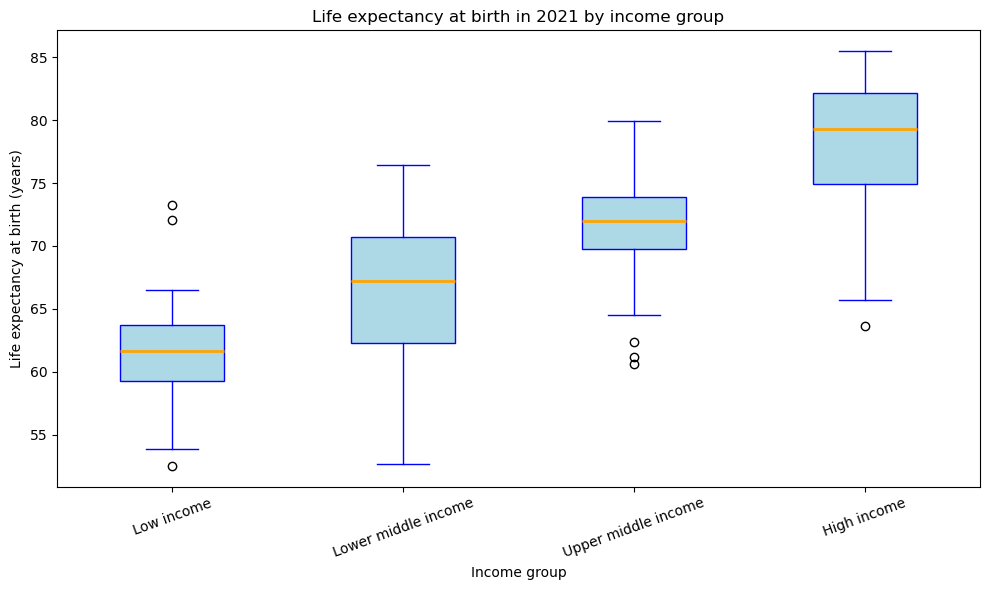

In [20]:
import matplotlib.pyplot as plt

# Choose the year and variable
year_of_interest = 2021
indicator = "life_expectancy_at_birth"

# Filter data
df_2021 = df[
    (df["year"] == year_of_interest) &
    df[indicator].notna() &
    df["income_group"].notna()
]

# Prepare data for plotting:
groups = ["Low income", "Lower middle income", "Upper middle income", "High income"]
data = [df_2021[df_2021["income_group"] == g][indicator] for g in groups]

plt.figure(figsize=(10, 6))

# Create boxplot with custom colors
box = plt.boxplot(
    data,
    patch_artist=True,        # needed to fill the box with color
    labels=groups,
    medianprops=dict(color="orange", linewidth=2),
)

# Fill box color
for patch in box['boxes']:
    patch.set_facecolor("lightblue")     # box color
    patch.set_edgecolor("blue")          # border color

# Whisker and cap color adjustments (optional)
for whisker in box['whiskers']:
    whisker.set_color("blue")

for cap in box['caps']:
    cap.set_color("blue")

# Title & labels
plt.title(f"Life expectancy at birth in {year_of_interest} by income group")
plt.ylabel("Life expectancy at birth (years)")
plt.xlabel("Income group")
plt.xticks(rotation=20)

plt.tight_layout()
plt.show()


In [21]:
# now we check if the conditions for an Anova are fulfilled
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols


# Filter data for 2021

year_of_interest = 2021
indicator = "life_expectancy_at_birth"

df_2021 = df[
    (df["year"] == year_of_interest) &
    df[indicator].notna() &
    df["income_group"].notna()
].copy()  # copy to avoid warnings

print(f"Number of rows for {year_of_interest}:", len(df_2021))
print("\nNumber of countries per income group:")
print(df_2021["income_group"].value_counts())

# Log-transform the indicator
# We use natural logarithm. Life expectancy is always > 0, so this is safe.
df_2021["life_expectancy_log"] = np.log(df_2021[indicator])

print("\nSummary of original life expectancy:")
print(df_2021[indicator].describe())

print("\nSummary of log-transformed life expectancy:")
print(df_2021["life_expectancy_log"].describe())


# Check equal variances (Levene test)
#    on the log-transformed variable

groups = ["Low income", "Lower middle income", "Upper middle income", "High income"]

group_data = [
    df_2021[df_2021["income_group"] == g]["life_expectancy_log"].dropna()
    for g in groups
]

levene_stat, levene_p = stats.levene(*group_data)

print("\nLevene test for equal variances (log-transformed):")
print("Statistic:", round(levene_stat, 3), "| p-value:", round(levene_p, 4))
print("Interpretation: p > 0.05 → variances can be considered equal.")


# check normality of the dependent variable
#    within each group (Shapiro-Wilk)
print("\nShapiro-Wilk tests for normality per income group (log-transformed):")

for g, data in zip(groups, group_data):
    if len(data) >= 3:  # Shapiro needs at least a few observations
        w_stat, p_val = stats.shapiro(data)
        print(f"{g}: W = {round(w_stat, 3)}, p = {round(p_val, 4)}")
    else:
        print(f"{g}: not enough data for Shapiro test")


print("\nInterpretation: p > 0.05 → cannot reject normality for that group.")



# Fit ANOVA model (to get residuals)
# We do not interpret the ANOVA yet, only residuals.

model = ols("life_expectancy_log ~ C(income_group)", data=df_2021).fit()

residuals = model.resid

# Shapiro-Wilk test for normality of residuals
w_resid, p_resid = stats.shapiro(residuals)
print("\nShapiro-Wilk test for normality of residuals:")
print("W =", round(w_resid, 3), "| p =", round(p_resid, 4))
print("Interpretation: p > 0.05 → residuals approximately normal.")




Number of rows for 2021: 206

Number of countries per income group:
income_group
High income            78
Upper middle income    54
Lower middle income    49
Low income             25
Name: count, dtype: int64

Summary of original life expectancy:
count    206.000000
mean      71.754570
std        7.709830
min       52.525000
25%       66.123750
50%       72.461000
75%       77.285628
max       85.492683
Name: life_expectancy_at_birth, dtype: float64

Summary of log-transformed life expectancy:
count    206.000000
mean       4.267280
std        0.110715
min        3.961289
25%        4.191528
50%        4.283048
75%        4.347506
max        4.448431
Name: life_expectancy_log, dtype: float64

Levene test for equal variances (log-transformed):
Statistic: 4.352 | p-value: 0.0054
Interpretation: p > 0.05 → variances can be considered equal.

Shapiro-Wilk tests for normality per income group (log-transformed):
Low income: W = 0.962, p = 0.4516
Lower middle income: W = 0.959, p = 0.0899
U

In [22]:
# run anova
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# ANOVA-Modell (log-transformierte Lebenserwartung ~ Income Group)
model = ols("life_expectancy_log ~ C(income_group)", data=df_2021).fit()

anova_table = anova_lm(model, typ=3)
print(anova_table)


                      sum_sq     df              F         PR(>F)
Intercept        1483.712029    1.0  304388.755552  5.434722e-323
C(income_group)     1.528235    3.0     104.507611   7.129328e-41
Residual            0.984628  202.0            NaN            NaN


In [23]:
# post test
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Tukey HSD post-hoc test on the log-transformed life expectancy
tukey = pairwise_tukeyhsd(
    endog=df_2021["life_expectancy_log"],   # dependent variable (log life expectancy)
    groups=df_2021["income_group"],        # group variable
    alpha=0.05                             # significance level
)

print(tukey)


             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       group1              group2       meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------
        High income          Low income  -0.2438    0.0 -0.2854 -0.2023   True
        High income Lower middle income  -0.1693    0.0 -0.2022 -0.1363   True
        High income Upper middle income  -0.0926    0.0 -0.1246 -0.0606   True
         Low income Lower middle income   0.0746 0.0001  0.0301   0.119   True
         Low income Upper middle income   0.1512    0.0  0.1075   0.195   True
Lower middle income Upper middle income   0.0766    0.0   0.041  0.1123   True
------------------------------------------------------------------------------


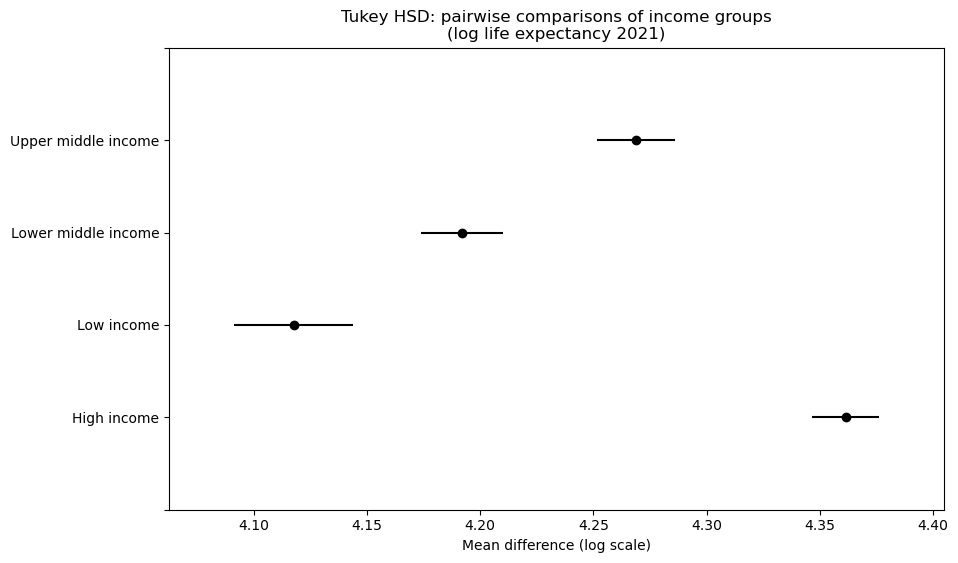

In [24]:
tukey.plot_simultaneous()
plt.title("Tukey HSD: pairwise comparisons of income groups\n(log life expectancy 2021)")
plt.xlabel("Mean difference (log scale)")
plt.show()


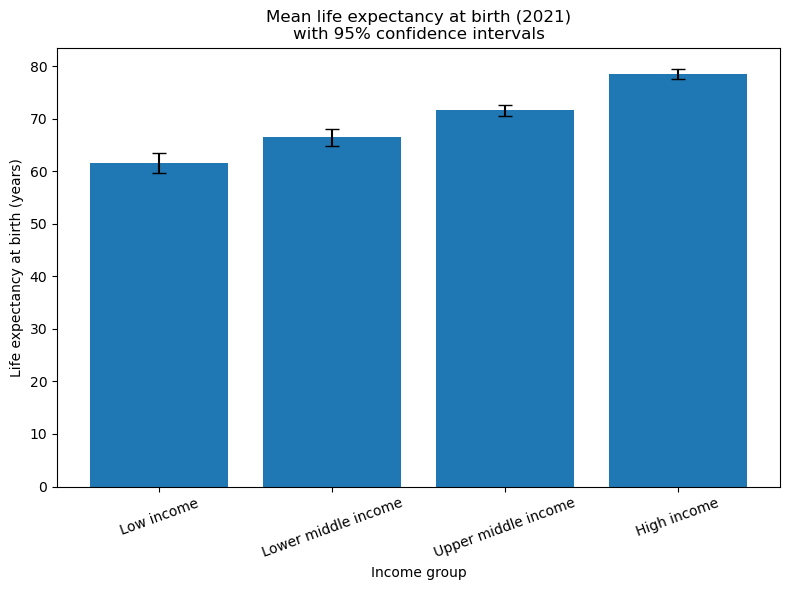

In [25]:
# visualizations:
import numpy as np
import matplotlib.pyplot as plt

indicator = "life_expectancy_at_birth"

# 1) Gruppenstatistiken berechnen
group_stats = df_2021.groupby("income_group")[indicator].agg(["mean", "std", "count"])

# Reihenfolge der Gruppen festlegen
order = ["Low income", "Lower middle income", "Upper middle income", "High income"]
group_stats = group_stats.loc[order]

# 2) Standardfehler und 95%-Konfidenzintervall
group_stats["se"] = group_stats["std"] / np.sqrt(group_stats["count"])
z = 1.96  # ~95% CI
group_stats["ci"] = z * group_stats["se"]

# 3) Plot
plt.figure(figsize=(8, 6))

x_pos = np.arange(len(order))

plt.bar(x_pos, group_stats["mean"], yerr=group_stats["ci"], capsize=5)

plt.xticks(x_pos, order, rotation=20)
plt.ylabel("Life expectancy at birth (years)")
plt.xlabel("Income group")
plt.title("Mean life expectancy at birth (2021)\nwith 95% confidence intervals")

plt.tight_layout()
plt.show()


now let us check the same stuff for the year 1960

Number of rows for 1960: 201
Countries per income group:
income_group
High income            74
Upper middle income    54
Lower middle income    48
Low income             25
Name: count, dtype: int64 



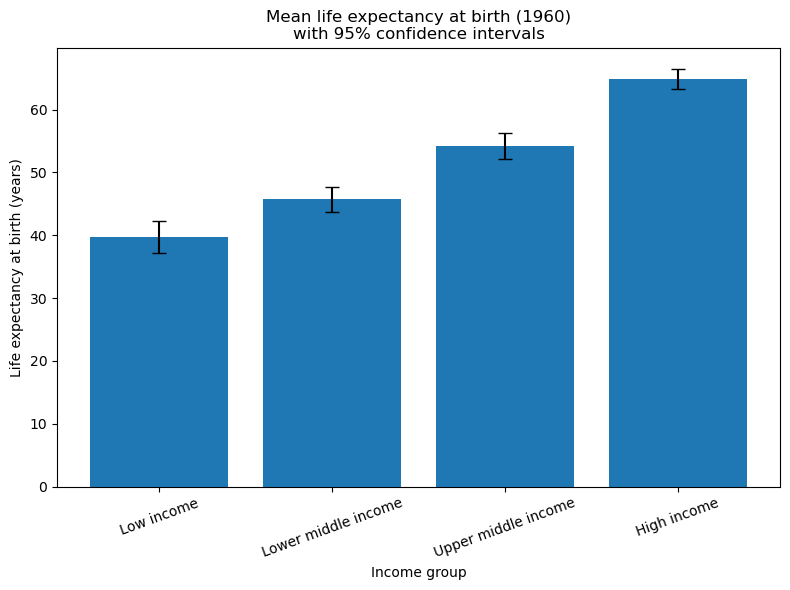

In [26]:
import numpy as np
import matplotlib.pyplot as plt

indicator = "life_expectancy_at_birth"

# ---- Helper function: barplot with 95% CI for a given year ----
def plot_life_expectancy_bar(year):
    # Filter data for the chosen year
    df_year = df[
        (df["year"] == year) &
        df[indicator].notna() &
        df["income_group"].notna()
    ].copy()

    print(f"Number of rows for {year}:", len(df_year))
    print("Countries per income group:")
    print(df_year["income_group"].value_counts(), "\n")

    # Compute group statistics
    group_stats = df_year.groupby("income_group")[indicator].agg(["mean", "std", "count"])

    # Order the income groups
    order = ["Low income", "Lower middle income", "Upper middle income", "High income"]
    group_stats = group_stats.loc[order]

    # Standard error and 95% CI
    group_stats["se"] = group_stats["std"] / np.sqrt(group_stats["count"])
    z = 1.96  # approx 95% CI
    group_stats["ci"] = z * group_stats["se"]

    # Make the bar plot
    plt.figure(figsize=(8, 6))
    x_pos = np.arange(len(order))

    plt.bar(x_pos, group_stats["mean"], yerr=group_stats["ci"], capsize=5)
    plt.xticks(x_pos, order, rotation=20)
    plt.ylabel("Life expectancy at birth (years)")
    plt.xlabel("Income group")
    plt.title(f"Mean life expectancy at birth ({year})\nwith 95% confidence intervals")
    plt.tight_layout()
    plt.show()

# Plot for 1960
plot_life_expectancy_bar(1960)


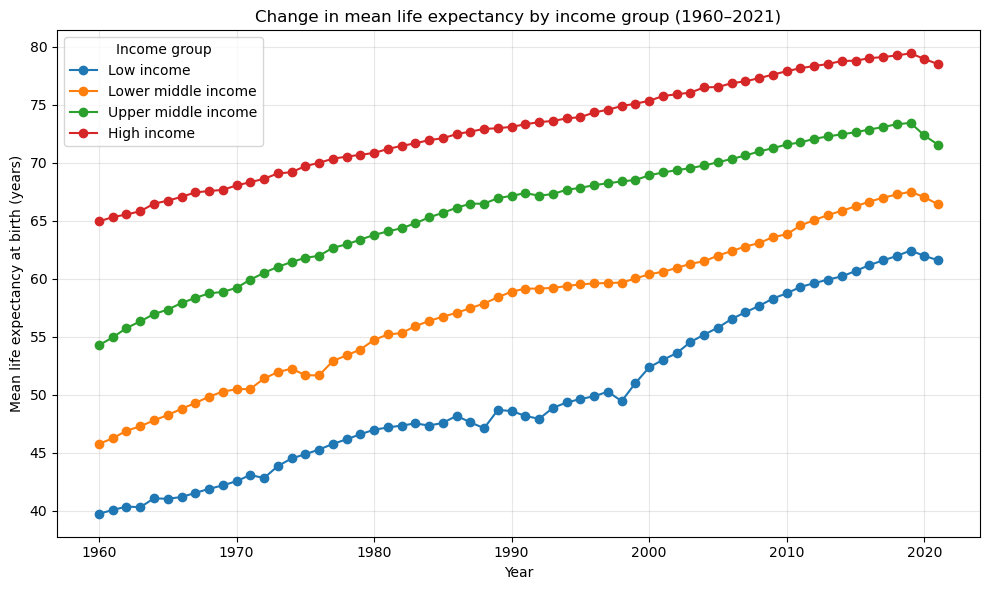

In [27]:
# Filter to reasonable years and complete cases
df_long = df[
    (df["year"] >= 1960) &
    (df["year"] <= 2021) &
    df[indicator].notna() &
    df["income_group"].notna()
].copy()

# Compute mean life expectancy per year and income group
group_means = (
    df_long
    .groupby(["year", "income_group"])[indicator]
    .mean()
    .reset_index()
)

# Pivot to wide format: one column per income group
pivot_means = group_means.pivot(index="year", columns="income_group", values=indicator)

# Order columns if they all exist
order = ["Low income", "Lower middle income", "Upper middle income", "High income"]
cols_to_plot = [c for c in order if c in pivot_means.columns]

plt.figure(figsize=(10, 6))

for col in cols_to_plot:
    plt.plot(pivot_means.index, pivot_means[col], marker="o", label=col)

plt.xlabel("Year")
plt.ylabel("Mean life expectancy at birth (years)")
plt.title("Change in mean life expectancy by income group (1960–2021)")
plt.legend(title="Income group")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Access to electricity



Number of rows for 2021: 212

Number of countries per income group:
income_group
High income            85
Upper middle income    53
Lower middle income    49
Low income             25
Name: count, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_27488\3675866571.py:25: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



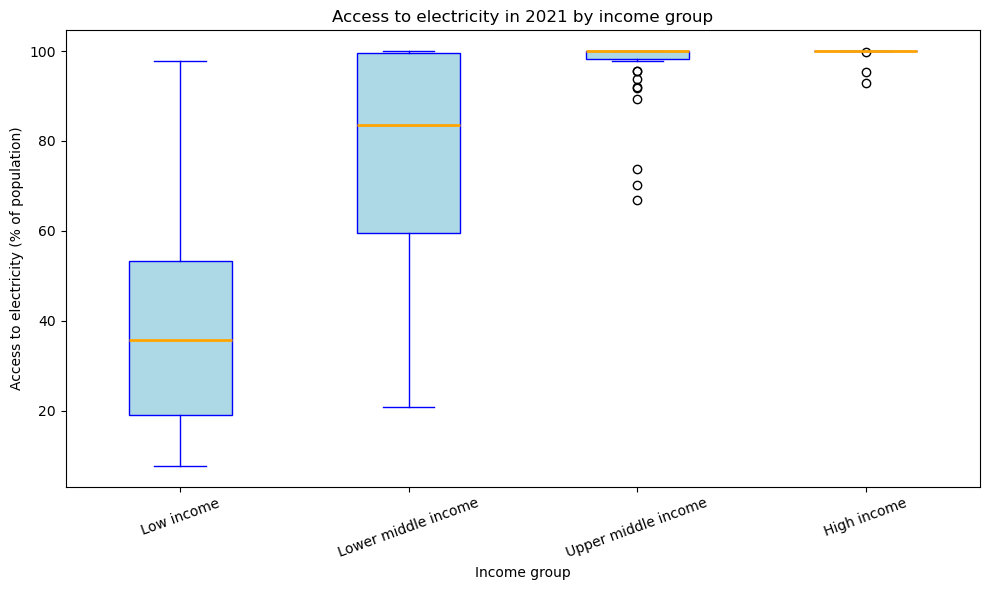

In [28]:
import matplotlib.pyplot as plt

# Choose the year and the variable
year_of_interest = 2021
indicator = "access_to_electricity%"

# 1) Filter data: year 2021, no missing in indicator, income_group not missing
df_elec_2021 = df[
    (df["year"] == year_of_interest) &
    df[indicator].notna() &
    df["income_group"].notna()
].copy()

print(f"Number of rows for {year_of_interest}:", len(df_elec_2021))
print("\nNumber of countries per income group:")
print(df_elec_2021["income_group"].value_counts())

# 2) Prepare data for plotting (same order as vorher)
groups = ["Low income", "Lower middle income", "Upper middle income", "High income"]
data = [df_elec_2021[df_elec_2021["income_group"] == g][indicator] for g in groups]

# 3) Create the boxplot with custom colors
plt.figure(figsize=(10, 6))

box = plt.boxplot(
    data,
    patch_artist=True,              # allows filling the box
    labels=groups,
    medianprops=dict(color="orange", linewidth=2),
)

# Fill box and set edge colors
for patch in box["boxes"]:
    patch.set_facecolor("lightblue")
    patch.set_edgecolor("blue")

# Optional: color whiskers and caps
for whisker in box["whiskers"]:
    whisker.set_color("blue")

for cap in box["caps"]:
    cap.set_color("blue")

# Titles and labels
plt.title(f"Access to electricity in {year_of_interest} by income group")
plt.ylabel("Access to electricity (% of population)")
plt.xlabel("Income group")
plt.xticks(rotation=20)

plt.tight_layout()
plt.show()


In [29]:
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols


# Filter data for 2021
year_of_interest = 2021
indicator = "access_to_electricity%"

df_elec_2021 = df[
    (df["year"] == year_of_interest) &
    df[indicator].notna() &
    df["income_group"].notna()
].copy()

print(f"Number of rows for {year_of_interest}:", len(df_elec_2021))
print("\nNumber of countries per income group:")
print(df_elec_2021["income_group"].value_counts())



# Log-transform the indicator
#    We drop rows where access_to_electricity% == 0,
#    because log(0) is not defined.

df_elec_2021 = df_elec_2021[df_elec_2021[indicator] > 0].copy()

df_elec_2021["access_log"] = np.log(df_elec_2021[indicator])

print("\nSummary of original access_to_electricity%:")
print(df_elec_2021[indicator].describe())

print("\nSummary of log-transformed access_to_electricity%:")
print(df_elec_2021["access_log"].describe())



# Check equal variances (Levene test) on log variable

groups = ["Low income", "Lower middle income", "Upper middle income", "High income"]

group_data = [
    df_elec_2021[df_elec_2021["income_group"] == g]["access_log"].dropna()
    for g in groups
]

levene_stat, levene_p = stats.levene(*group_data)

print("\nLevene test for equal variances (log-transformed):")
print("Statistic:", round(levene_stat, 3), "| p-value:", round(levene_p, 4))
print("Interpretation: p > 0.05 → variances can be considered equal.")



# Check normality of the dependent variable (per group)

print("\nShapiro-Wilk tests for normality per income group (log-transformed):")

for g, data in zip(groups, group_data):
    if len(data) >= 3:
        w_stat, p_val = stats.shapiro(data)
        print(f"{g}: W = {round(w_stat, 3)}, p = {round(p_val, 4)}")
    else:
        print(f"{g}: not enough data for Shapiro test")

print("\nInterpretation: p > 0.05 → cannot reject normality for that group.")



# Fit ANOVA model (log access ~ income_group) to get residuals

model_elec = ols("access_log ~ C(income_group)", data=df_elec_2021).fit()
residuals_elec = model_elec.resid

w_resid, p_resid = stats.shapiro(residuals_elec)
print("\nShapiro-Wilk test for normality of residuals:")
print("W =", round(w_resid, 3), "| p =", round(p_resid, 4))
print("Interpretation: p > 0.05 → residuals approximately normal.")





Number of rows for 2021: 212

Number of countries per income group:
income_group
High income            85
Upper middle income    53
Lower middle income    49
Low income             25
Name: count, dtype: int64

Summary of original access_to_electricity%:
count    212.000000
mean      87.212099
std       23.599004
min        7.747763
25%       87.531953
50%      100.000000
75%      100.000000
max      100.000000
Name: access_to_electricity%, dtype: float64

Summary of log-transformed access_to_electricity%:
count    212.000000
mean       4.397957
std        0.454375
min        2.047404
25%        4.471971
50%        4.605170
75%        4.605170
max        4.605170
Name: access_log, dtype: float64

Levene test for equal variances (log-transformed):
Statistic: 75.451 | p-value: 0.0
Interpretation: p > 0.05 → variances can be considered equal.

Shapiro-Wilk tests for normality per income group (log-transformed):
Low income: W = 0.953, p = 0.2855
Lower middle income: W = 0.818, p = 0.0
Upp

ANOVA table for log(access_to_electricity%)

                      sum_sq     df             F         PR(>F)
Intercept        1801.500497    1.0  20949.043889  9.457568e-211
C(income_group)    25.675607    3.0     99.524334   5.558855e-40
Residual           17.886836  208.0           NaN            NaN

Tukey HSD post-hoc test for income_group (log access):

             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       group1              group2       meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------
        High income          Low income  -1.1007    0.0 -1.2735 -0.9279   True
        High income Lower middle income  -0.2967    0.0 -0.4329 -0.1605   True
        High income Upper middle income  -0.0295 0.9396 -0.1624  0.1034  False
         Low income Lower middle income   0.8041    0.0  0.6174  0.9907   True
         Low income Upper middle income   1.0713    0.0   0.887  1.2555   True
Lower 

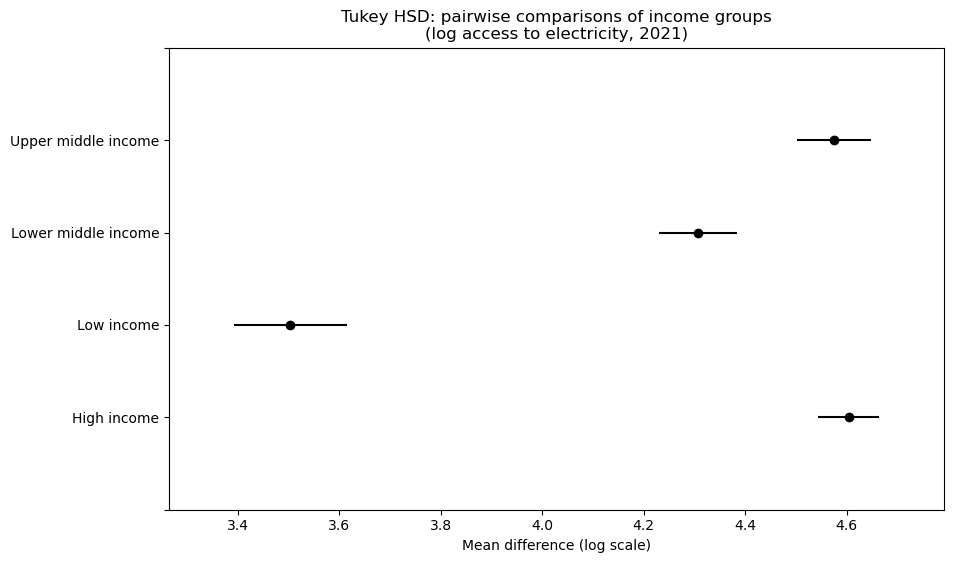

In [30]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt


# ANOVA (Type III) on log-transformed access values


# Fit the linear model: log(access) ~ income_group
model_elec = ols("access_log ~ C(income_group)", data=df_elec_2021).fit()

# Type III ANOVA table
anova_elec = anova_lm(model_elec, typ=3)
print("ANOVA table for log(access_to_electricity%)\n")
print(anova_elec)



# Tukey HSD post-hoc test


tukey_elec = pairwise_tukeyhsd(
    endog=df_elec_2021["access_log"],      # dependent variable (log access)
    groups=df_elec_2021["income_group"],   # group variable
    alpha=0.05
)

print("\nTukey HSD post-hoc test for income_group (log access):\n")
print(tukey_elec)


tukey_elec.plot_simultaneous()
plt.title("Tukey HSD: pairwise comparisons of income groups\n(log access to electricity, 2021)")
plt.xlabel("Mean difference (log scale)")
plt.show()


Now we visualize this variable:

In [ ]:
import pandas as pd
import plotly.express as px


# Data preparation

year_of_interest = 2021
indicator = "access_to_electricity%"

all_countries = df[["country"]].drop_duplicates()

elec_2021 = (
    df[(df["year"] == year_of_interest)]
    .dropna(subset=[indicator])
    .groupby("country", as_index=False)[indicator]
    .mean()
)

map_df = all_countries.merge(elec_2021, on="country", how="left")


# Choroplethen-map

fig = px.choropleth(
    map_df,
    locations="country",                 
    locationmode="country names",
    color=indicator,                     
    color_continuous_scale=[(0, "black"), (1, "yellow")],  
    range_color=(0, 100),              # von 0% bis 100%
    title=f"Access to electricity in {year_of_interest} (% of population)",
    labels={indicator: "Access to electricity (%)"},
)


fig.update_layout(
    coloraxis_colorbar=dict(
        title="Access to electricity (%)",
        ticks="outside"
    ),
    margin=dict(l=0, r=0, t=50, b=0),
)


fig.show()


In [37]:
import pandas as pd

indicator = "access_to_electricity%"

# 1) Make sure the year column exists and has no weird types

df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year"] = df["date"].dt.year

# 2) For each year: count total rows and missing values for the indicator
summary_list = []

for year, group in df.groupby("year"):
    total_rows = len(group)
    missing_count = group[indicator].isna().sum()
    missing_percent = round(missing_count / total_rows * 100, 2) if total_rows > 0 else None
    
    summary_list.append({
        "year": int(year),
        "total_rows": total_rows,
        "missing_count": missing_count,
        "missing_percent": missing_percent
    })

missing_summary_elec = pd.DataFrame(summary_list).sort_values("year")

missing_summary_elec
pd.set_option("display.max_rows", None)   # show ALL rows
print(missing_summary_elec)
pd.reset_option("display.max_rows")       # optional: reset afterwards



    year  total_rows  missing_count  missing_percent
0   1960         214            214           100.00
1   1961         214            214           100.00
2   1962         214            214           100.00
3   1963         214            214           100.00
4   1964         214            214           100.00
5   1965         214            214           100.00
6   1966         214            214           100.00
7   1967         214            214           100.00
8   1968         214            214           100.00
9   1969         214            214           100.00
10  1970         214            214           100.00
11  1971         214            214           100.00
12  1972         214            214           100.00
13  1973         214            214           100.00
14  1974         214            214           100.00
15  1975         214            214           100.00
16  1976         214            214           100.00
17  1977         214            214           

In [38]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

indicator = "access_to_electricity%"

def prepare_map_df(df, year, indicator):
    """Return dataframe with one row per country and mean indicator value for the given year."""
    # All unique countries
    all_countries = df[["country"]].drop_duplicates()

    # Mean value per country for the given year (ignoring missing values)
    year_values = (
        df[(df["year"] == year)]
        .dropna(subset=[indicator])
        .groupby("country", as_index=False)[indicator]
        .mean()
    )

    # Merge so that countries without data keep NaN
    map_df = all_countries.merge(year_values, on="country", how="left")
    return map_df

# Prepare data for both years
year_left = 2000
year_right = 2021

map_df_2000 = prepare_map_df(df, year_left, indicator)
map_df_2021 = prepare_map_df(df, year_right, indicator)

# Create figure with two choropleth subplots
fig = make_subplots(
    rows=1,
    cols=2,
    specs=[[{"type": "choropleth"}, {"type": "choropleth"}]],
    subplot_titles=(
        f"Access to electricity in {year_left} (% of population)",
        f"Access to electricity in {year_right} (% of population)"
    )
)

# Left map (year 2000) – no separate colorbar
fig.add_trace(
    go.Choropleth(
        locations=map_df_2000["country"],
        locationmode="country names",
        z=map_df_2000[indicator],
        colorscale=[(0, "black"), (1, "yellow")],
        zmin=0,
        zmax=100,
        colorbar=None,   # colorbar only on the right plot
        showscale=False
    ),
    row=1, col=1
)

# Right map (year 2021) – with shared colorbar
fig.add_trace(
    go.Choropleth(
        locations=map_df_2021["country"],
        locationmode="country names",
        z=map_df_2021[indicator],
        colorscale=[(0, "black"), (1, "yellow")],
        zmin=0,
        zmax=100,
        colorbar=dict(
            title="Access to electricity (%)",
            ticks="outside"
        ),
        showscale=True
    ),
    row=1, col=2
)

# Layout adjustments
fig.update_layout(
    title_text="Access to electricity by country: comparison of 2000 and 2021",
    margin=dict(l=0, r=0, t=60, b=0)
)

fig.show()


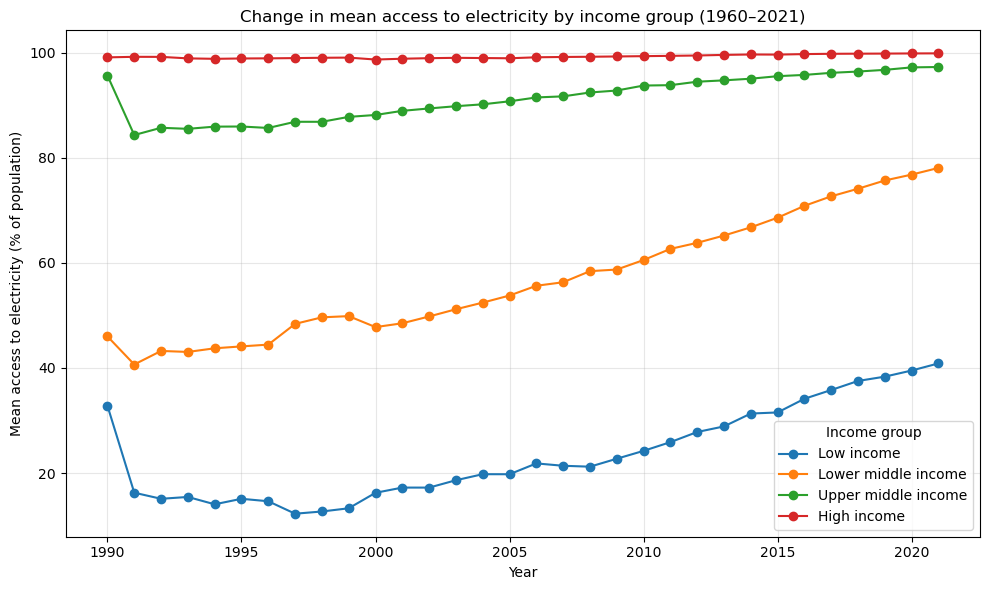

In [34]:
import matplotlib.pyplot as plt

# Choose the variable
indicator = "access_to_electricity%"

df_elec_long = df[
    df[indicator].notna() &
    df["income_group"].notna() &
    df["year"].notna()
].copy()


group_means_elec = (
    df_elec_long
    .groupby(["year", "income_group"])[indicator]
    .mean()
    .reset_index()
)

pivot_elec = group_means_elec.pivot(
    index="year",
    columns="income_group",
    values=indicator
)


order = ["Low income", "Lower middle income", "Upper middle income", "High income"]
cols_to_plot = [c for c in order if c in pivot_elec.columns]


plt.figure(figsize=(10, 6))

for col in cols_to_plot:
    plt.plot(pivot_elec.index, pivot_elec[col], marker="o", label=col)

plt.xlabel("Year")
plt.ylabel("Mean access to electricity (% of population)")
plt.title("Change in mean access to electricity by income group (1960–2021)")
plt.legend(title="Income group")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Next variable: Government expenditure on education

Number of rows for 2020: 158

Number of countries per income group:
income_group
High income            61
Upper middle income    44
Lower middle income    38
Low income             15
Name: count, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_27488\3045230325.py:25: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



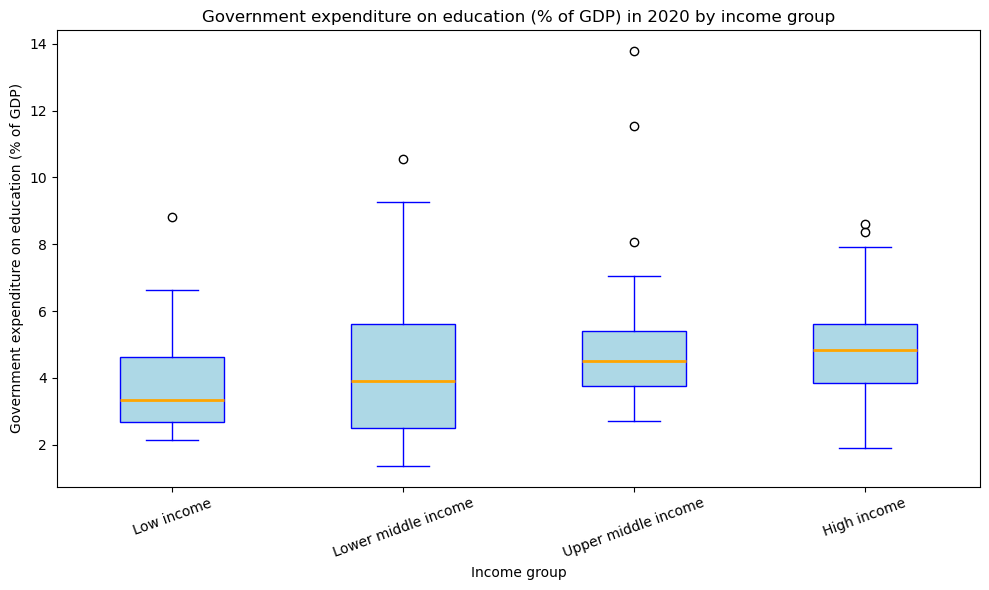

In [49]:
import matplotlib.pyplot as plt

# Choose year and variable
year_of_interest = 2020
indicator = "government_expenditure_on_education%"

# 1) Filter data: year 2020, valid indicator values, and non-missing income group
df_edu_2020 = df[
    (df["year"] == year_of_interest) &
    df[indicator].notna() &
    df["income_group"].notna()
].copy()

print(f"Number of rows for {year_of_interest}:", len(df_edu_2020))
print("\nNumber of countries per income group:")
print(df_edu_2020["income_group"].value_counts())

# 2) Prepare data for plotting in the desired order
groups = ["Low income", "Lower middle income", "Upper middle income", "High income"]
data = [df_edu_2020[df_edu_2020["income_group"] == g][indicator] for g in groups]

# 3) Create the styled boxplot
plt.figure(figsize=(10, 6))

box = plt.boxplot(
    data,
    patch_artist=True,                # allows filled boxes
    labels=groups,
    medianprops=dict(color="orange", linewidth=2),
)

# Color settings: light blue boxes, blue borders/whiskers/caps
for patch in box["boxes"]:
    patch.set_facecolor("lightblue")
    patch.set_edgecolor("blue")

for whisker in box["whiskers"]:
    whisker.set_color("blue")

for cap in box["caps"]:
    cap.set_color("blue")

# Titles and labels
plt.title(f"Government expenditure on education (% of GDP) in {year_of_interest} by income group")
plt.ylabel("Government expenditure on education (% of GDP)")
plt.xlabel("Income group")
plt.xticks(rotation=20)

plt.tight_layout()
plt.show()


In [41]:
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols


# Filter data for 2020

year_of_interest = 2020
indicator = "government_expenditure_on_education%"

df_edu_2020 = df[
    (df["year"] == year_of_interest) &
    df[indicator].notna() &
    df["income_group"].notna()
].copy()

print(f"Number of rows for {year_of_interest}:", len(df_edu_2020))
print("\nNumber of countries per income group:")
print(df_edu_2020["income_group"].value_counts())


# Log-transform the indicator
#    (remove non-positive values first)

df_edu_2020 = df_edu_2020[df_edu_2020[indicator] > 0].copy()
df_edu_2020["edu_log"] = np.log(df_edu_2020[indicator])

print("\nSummary of original government_expenditure_on_education%:")
print(df_edu_2020[indicator].describe())

print("\nSummary of log-transformed government_expenditure_on_education%:")
print(df_edu_2020["edu_log"].describe())



# Equal sample sizes (just inspect counts)

print("\nGroup sizes (after log filtering):")
print(df_edu_2020["income_group"].value_counts())



# Check equal variances (Levene test)

groups = ["Low income", "Lower middle income", "Upper middle income", "High income"]

group_data = [
    df_edu_2020[df_edu_2020["income_group"] == g]["edu_log"].dropna()
    for g in groups
]

levene_stat, levene_p = stats.levene(*group_data)

print("\nLevene test for equal variances (log-transformed):")
print("Statistic:", round(levene_stat, 3), "| p-value:", round(levene_p, 4))
print("Rule of thumb: p > 0.05 → variances can be considered equal.")



# Normality of the dependent variable per group

print("\nShapiro-Wilk tests for normality per income group (log-transformed):")

for g, data in zip(groups, group_data):
    if len(data) >= 3:
        w_stat, p_val = stats.shapiro(data)
        print(f"{g}: W = {round(w_stat, 3)}, p = {round(p_val, 4)}")
    else:
        print(f"{g}: not enough data for Shapiro test")

print("\nRule of thumb: p > 0.05 → cannot reject normality for that group.")



# Fit ANOVA model to get residuals

model_edu = ols("edu_log ~ C(income_group)", data=df_edu_2020).fit()
residuals_edu = model_edu.resid

w_resid, p_resid = stats.shapiro(residuals_edu)
print("\nShapiro-Wilk test for normality of residuals:")
print("W =", round(w_resid, 3), "| p =", round(p_resid, 4))
print("Rule of thumb: p > 0.05 → residuals approximately normal.")




Number of rows for 2020: 158

Number of countries per income group:
income_group
High income            61
Upper middle income    44
Lower middle income    38
Low income             15
Name: count, dtype: int64

Summary of original government_expenditure_on_education%:
count    158.000000
mean       4.674570
std        1.881792
min        1.371014
25%        3.411115
50%        4.507715
75%        5.582945
max       13.779448
Name: government_expenditure_on_education%, dtype: float64

Summary of log-transformed government_expenditure_on_education%:
count    158.000000
mean       1.465798
std        0.397114
min        0.315551
25%        1.227039
50%        1.505790
75%        1.719715
max        2.623178
Name: edu_log, dtype: float64

Group sizes (after log filtering):
income_group
High income            61
Upper middle income    44
Lower middle income    38
Low income             15
Name: count, dtype: int64

Levene test for equal variances (log-transformed):
Statistic: 5.767 | p-val

ANOVA table for log(government_expenditure_on_education%):

                     sum_sq     df           F        PR(>F)
Intercept        144.518309    1.0  973.096990  1.892404e-68
C(income_group)    1.887735    3.0    4.236946  6.565650e-03
Residual          22.871122  154.0         NaN           NaN

Tukey HSD post-hoc test for income_group (log education expenditure):

             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       group1              group2       meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------
        High income          Low income  -0.2466 0.1223 -0.5351  0.0419  False
        High income Lower middle income   -0.219 0.0334 -0.4259 -0.0122   True
        High income Upper middle income   0.0096 0.9993 -0.1883  0.2076  False
         Low income Lower middle income   0.0276 0.9954 -0.2776  0.3328  False
         Low income Upper middle income   0.2562 0.1214  -0.043  0.5555

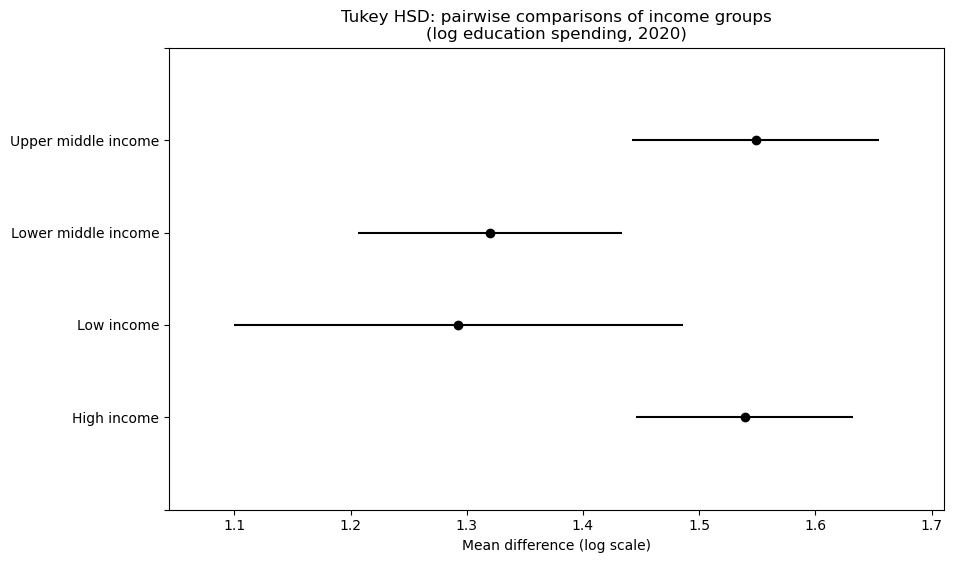

In [43]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt


# ANOVA (Type III) on log education spend


# Fit linear model
model_edu = ols("edu_log ~ C(income_group)", data=df_edu_2020).fit()

# Type III ANOVA table
anova_edu = anova_lm(model_edu, typ=3)
print("ANOVA table for log(government_expenditure_on_education%):\n")
print(anova_edu)


# Tukey HSD post-hoc test


tukey_edu = pairwise_tukeyhsd(
    endog=df_edu_2020["edu_log"],       # dependent variable (log education expenditure)
    groups=df_edu_2020["income_group"], # factor
    alpha=0.05
)

print("\nTukey HSD post-hoc test for income_group (log education expenditure):\n")
print(tukey_edu)

# plot Tukey results
tukey_edu.plot_simultaneous()
plt.title("Tukey HSD: pairwise comparisons of income groups\n(log education spending, 2020)")
plt.xlabel("Mean difference (log scale)")
plt.show()


Top 5 countries in 2020
country
Marshall Islands         13.779448
Cuba                     11.524796
Micronesia, Fed. Sts.    10.539216
Namibia                   9.277999
Sierra Leone              8.809550
Name: government_expenditure_on_education%, dtype: float64


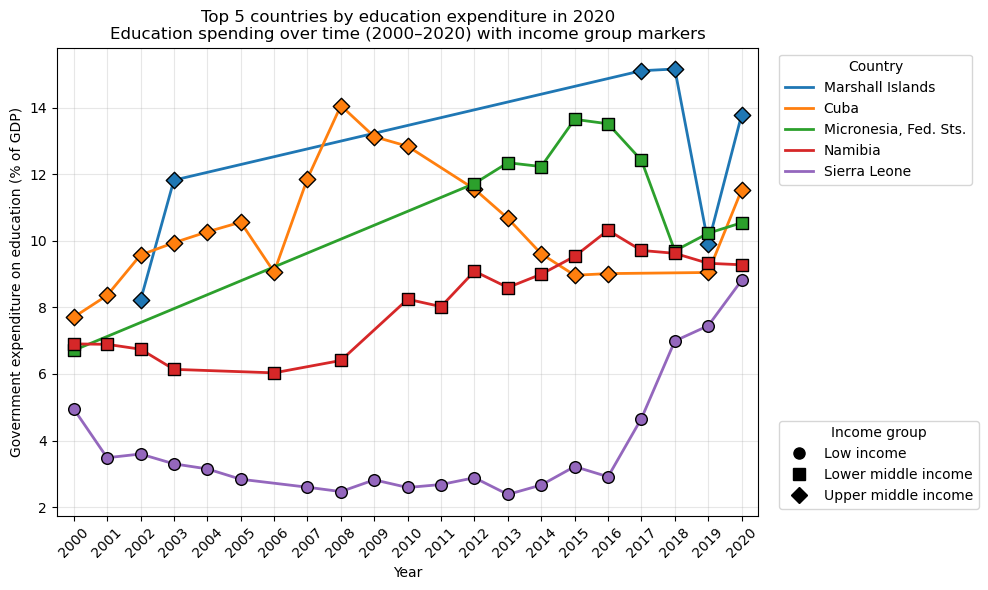

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

indicator = "government_expenditure_on_education%"
ref_year = 2020

# 1) Top 5 countries in 2020
df_2020 = df[
    (df["year"] == ref_year) &
    df[indicator].notna() &
    df["country"].notna()
].copy()

top_2020 = (
    df_2020.groupby("country")[indicator]
    .mean()
    .sort_values(ascending=False)
    .head(5)
)
top_countries = top_2020.index.tolist()

print("Top 5 countries in", ref_year)
print(top_2020)

# 2) Filter 2000–2020 for these countries
df_top = df[
    df["country"].isin(top_countries) &
    df[indicator].notna() &
    df["year"].between(2000, 2020) &
    df["income_group"].notna()
].copy()

df_top = df_top.sort_values(["country", "year"])

# Determine which income groups actually appear
income_groups_present = sorted(df_top["income_group"].unique())

# 3) Marker map only for groups that actually exist
marker_map_full = {
    "Low income": "o",
    "Lower middle income": "s",
    "Upper middle income": "D",
    "High income": "^",
}

marker_map = {ig: marker_map_full[ig] for ig in income_groups_present}

# 4) Prepare colors for each country
color_cycle = plt.cm.tab10.colors
country_colors = {c: color_cycle[i] for i, c in enumerate(top_countries)}

# 5) Plot
fig, ax = plt.subplots(figsize=(10, 6))

for country in top_countries:
    data_c = df_top[df_top["country"] == country]

    # Line for the country
    ax.plot(
        data_c["year"],
        data_c[indicator],
        color=country_colors[country],
        linewidth=2,
        label=country
    )

    # Markers for income groups
    for inc_group, group_data in data_c.groupby("income_group"):
        ax.scatter(
            group_data["year"],
            group_data[indicator],
            marker=marker_map[inc_group],
            color=country_colors[country],
            edgecolors="black",
            s=70,
            zorder=3
        )

# 6) Legend for countries (colors)
country_handles = [
    Line2D([0], [0], color=country_colors[c], linewidth=2)
    for c in top_countries
]

legend_countries = ax.legend(
    country_handles,
    top_countries,
    title="Country",
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0)
)
ax.add_artist(legend_countries)

# 7) Legend for income groups (only actual groups present)
income_handles = [
    Line2D(
        [0], [0],
        marker=marker_map[ig],
        color="black",
        linestyle="",
        markersize=8
    )
    for ig in marker_map.keys()
]

ax.legend(
    income_handles,
    list(marker_map.keys()),
    title="Income group",
    loc="lower left",
    bbox_to_anchor=(1.02, 0.0)
)

# 8) Fix x-axis: integer ticks only, 2000–2020
ax.set_xticks(list(range(2000, 2021)))
ax.set_xticklabels(list(range(2000, 2021)), rotation=45)
ax.set_xlim(1999.5, 2020.5)

# 9) Labels and title
ax.set_xlabel("Year")
ax.set_ylabel("Government expenditure on education (% of GDP)")
ax.set_title(
    "Top 5 countries by education expenditure in 2020\n"
    "Education spending over time (2000–2020) with income group markers"
)
ax.grid(True, alpha=0.3)



plt.tight_layout()
plt.show()


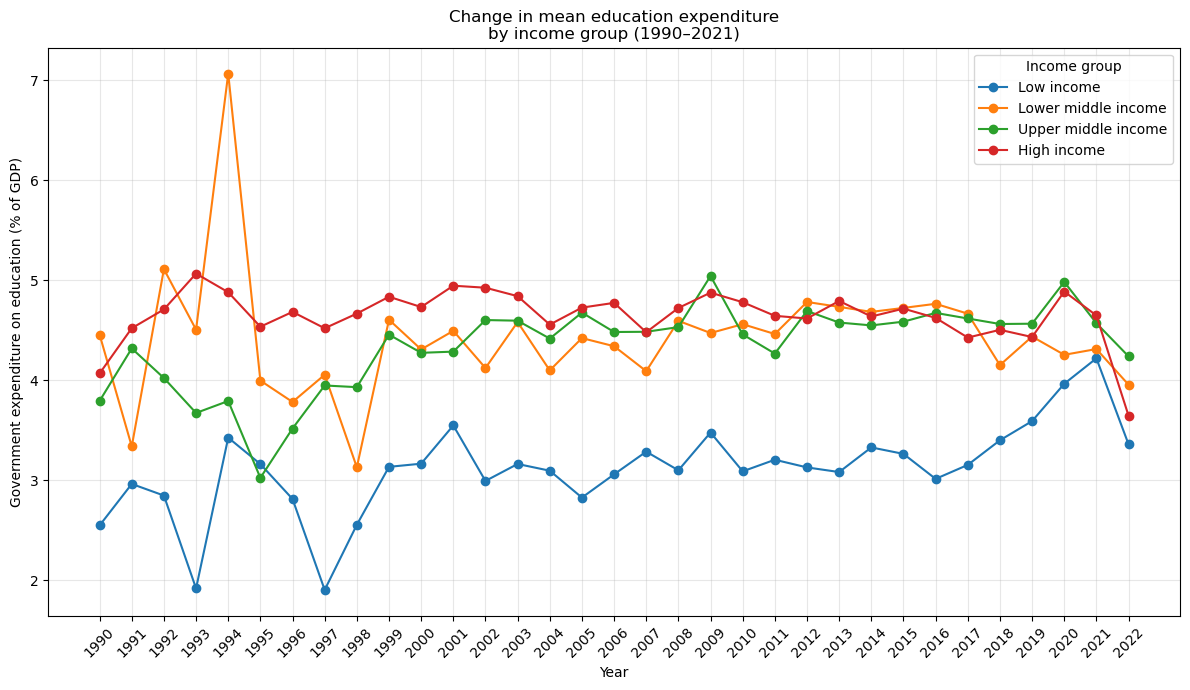

In [48]:
import matplotlib.pyplot as plt
import pandas as pd

indicator = "government_expenditure_on_education%"

# 1) Filter: keep only valid indicator values and income groups
df_edu_long = df[
    df[indicator].notna() &
    df["income_group"].notna() &
    df["year"].notna()
].copy()

# Optional: restrict to reasonable years (e.g., since 1990)
df_edu_long = df_edu_long[df_edu_long["year"] >= 1990]

# 2) Mean education expenditure per year & income group
group_means_edu = (
    df_edu_long
    .groupby(["year", "income_group"])[indicator]
    .mean()
    .reset_index()
)

# 3) Pivot for plotting: each income group becomes a column
pivot_edu = group_means_edu.pivot(
    index="year",
    columns="income_group",
    values=indicator
)

# 4) Ensure correct order of income groups
order = ["Low income", "Lower middle income", "Upper middle income", "High income"]
cols_to_plot = [c for c in order if c in pivot_edu.columns]

# 5) Plot
plt.figure(figsize=(12, 7))

for col in cols_to_plot:
    plt.plot(
        pivot_edu.index,
        pivot_edu[col],
        marker="o",
        label=col
    )

# Labels, title, legend
plt.xlabel("Year")
plt.ylabel("Government expenditure on education (% of GDP)")
plt.title("Change in mean education expenditure\nby income group (1990–2021)")
plt.legend(title="Income group")
plt.grid(True, alpha=0.3)

# Ensure integer years on axis
plt.xticks(range(int(pivot_edu.index.min()), int(pivot_edu.index.max()) + 1), rotation=45)

plt.tight_layout()
plt.show()
